<a href="https://colab.research.google.com/github/Sudeeppp-Mishra/LeafLens/blob/main/LeafLens_Train_on_DataSets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

# Attempt to unmount first to clear any existing state
drive.flush_and_unmount()

# Ensure the mount point directory is empty or doesn't exist
# This step forcefully removes the directory if it contains files
# and is a common workaround for persistent mountpoint issues.
if os.path.exists('/content/drive'):
    !rm -rf /content/drive

# Then mount with force_remount
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/datasets/PlantVillage"

selected_classes = [
    'Tomato_healthy',
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy'
]

class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
num_classes = len(selected_classes)

In [ ]:
image_paths = []
labels = []

for cls in selected_classes:
    cls_path = os.path.join(DATASET_DIR, cls)
    for img in os.listdir(cls_path):
        image_paths.append(os.path.join(cls_path, img))
        labels.append(class_to_idx[cls])

print("Total images:", len(image_paths))
print("Classes:", num_classes)

Total images: 18164
Classes: 13


In [ ]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
class SafePlantDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]

        try:
            image = cv2.imread(path)

            # 🔴 VERY IMPORTANT CHECK
            if image is None:
                raise ValueError(f"Corrupted image: {path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                image = self.transform(image)

            return image, self.labels[idx]

        except Exception as e:
            # Skip bad image safely
            return self.__getitem__((idx + 1) % len(self.paths))

In [ ]:
train_loader = DataLoader(
    SafePlantDataset(train_paths, train_labels, train_transform),
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    SafePlantDataset(val_paths, val_labels, val_transform),
    batch_size=32,
    shuffle=False
)

In [ ]:
from torchvision.models import EfficientNet_B0_Weights

model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 125MB/s] 


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
import torch
from tqdm import tqdm
import os

# =========================
# PARAMETERS
# =========================
epochs = 10
checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# =========================
# AUTO-FIND LATEST CHECKPOINT
# =========================
def find_latest_checkpoint(dir_path):
    files = [f for f in os.listdir(dir_path) if f.endswith(".pth")]
    if not files:
        return None
    files.sort()
    return os.path.join(dir_path, files[-1])

resume_checkpoint = find_latest_checkpoint(checkpoint_dir)
start_epoch = 0

# =========================
# RESUME LOGIC
# =========================
if resume_checkpoint:
    print(f"✅ Found checkpoint: {resume_checkpoint}")
    checkpoint = torch.load(resume_checkpoint, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    start_epoch = checkpoint["epoch"] + 1
    print(f"🔄 Resuming from Epoch {start_epoch+1}")
else:
    print("🚀 No checkpoint found. Starting from Epoch 1")

# =========================
# TRAINING LOOP
# =========================
for epoch in range(start_epoch, epochs):

    model.train()
    running_loss = 0.0

    print(f"\n🌱 Epoch {epoch+1}/{epochs}")
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"📉 Training Loss Epoch {epoch+1}: {avg_loss:.4f}")

    # =========================
    # SAVE CHECKPOINT
    # =========================
    checkpoint_path = os.path.join(
        checkpoint_dir, f"checkpoint_epoch{epoch+1}.pth"
    )

    torch.save({
        "epoch": epoch,   # zero-indexed
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, checkpoint_path)

    print(f"💾 Checkpoint saved: {checkpoint_path}")


🚀 No checkpoint found. Starting from Epoch 1

🌱 Epoch 1/10


📉 Training Loss Epoch 1: 0.1477
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch1.pth

🌱 Epoch 2/10


📉 Training Loss Epoch 2: 0.0643
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch2.pth

🌱 Epoch 3/10


📉 Training Loss Epoch 3: 0.0428
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch3.pth

🌱 Epoch 4/10


📉 Training Loss Epoch 4: 0.0315
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch4.pth

🌱 Epoch 5/10


📉 Training Loss Epoch 5: 0.0254
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch5.pth

🌱 Epoch 6/10


📉 Training Loss Epoch 6: 0.0196
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch6.pth

🌱 Epoch 7/10


📉 Training Loss Epoch 7: 0.0176
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch7.pth

🌱 Epoch 8/10


📉 Training Loss Epoch 8: 0.0164
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch8.pth

🌱 Epoch 9/10


📉 Training Loss Epoch 9: 0.0155
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch9.pth

🌱 Epoch 10/10


📉 Training Loss Epoch 10: 0.0172
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch10.pth


In [ ]:
# =========================
# SAVE FINAL TRAINED MODEL
# =========================
final_model_path = "/content/drive/MyDrive/checkpoints/final_trained_model.pth"

torch.save(model.state_dict(), final_model_path)

print(f"🎉 Final trained model saved at: {final_model_path}")


🎉 Final trained model saved at: /content/drive/MyDrive/checkpoints/final_trained_model.pth



📊 Validation Loss: 0.0176
🎯 Validation Accuracy: 99.45%


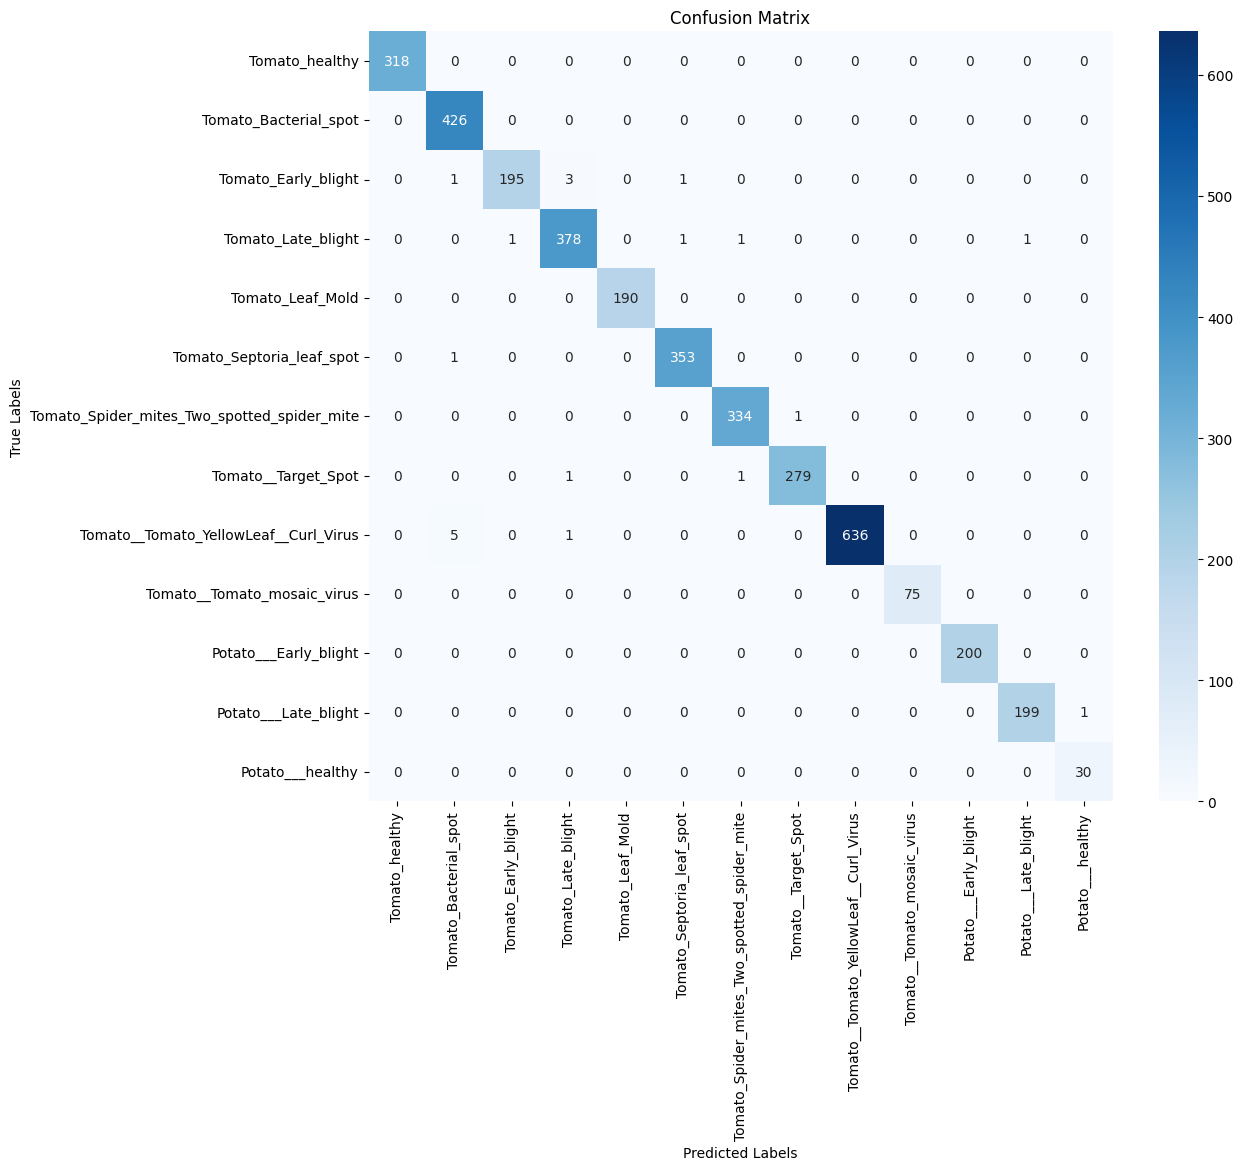


📑 Classification Report (Precision, Recall, F1-score):

                                             precision    recall  f1-score   support

                             Tomato_healthy       1.00      1.00      1.00       318
                      Tomato_Bacterial_spot       0.98      1.00      0.99       426
                        Tomato_Early_blight       0.99      0.97      0.98       200
                         Tomato_Late_blight       0.99      0.99      0.99       382
                           Tomato_Leaf_Mold       1.00      1.00      1.00       190
                  Tomato_Septoria_leaf_spot       0.99      1.00      1.00       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.99      1.00      1.00       335
                        Tomato__Target_Spot       1.00      0.99      0.99       281
      Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      0.99      1.00       642
                Tomato__Tomato_mosaic_virus       1.00      1.00      1.00        75
       

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# VALIDATION LOOP
# =========================
model.eval()
all_preds = []
all_labels = []
val_running_loss = 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# =========================
# VALIDATION METRICS
# =========================
val_loss = val_running_loss / len(val_loader)
val_accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

print(f"\n📊 Validation Loss: {val_loss:.4f}")
print(f"🎯 Validation Accuracy: {val_accuracy:.2f}%")

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# =========================
# CLASSIFICATION REPORT (Precision, Recall, F1-score)
# =========================
report = classification_report(all_labels, all_preds, target_names=selected_classes)
print("\n📑 Classification Report (Precision, Recall, F1-score):\n")
print(report)


In [ ]:
from PIL import Image
from torchvision import transforms

# Preprocessing function (same as validation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return val_transform(image).unsqueeze(0)  # Add batch dimension

# Prediction function
def predict(model, image_tensor, class_names):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor.to(device))
        _, predicted = torch.max(outputs, 1)
        return class_names[predicted.item()]

# Example usage
image_tensor = preprocess_image("/content/drive/MyDrive/datasets/PlantVillage/Tomato_healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG")
result = predict(model, image_tensor, selected_classes)
print("Predicted class:", result)


Predicted class: Tomato_healthy
